In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib


In [ ]:
BASE_DIR = r"C:\Users\cherr\Downloads\ml-dataset"

TRAIN_DIR = os.path.join(BASE_DIR, "train_images")
VAL_DIR   = os.path.join(BASE_DIR, "val_images")

TRAIN_CSV = os.path.join(BASE_DIR, "train_1.csv")
VAL_CSV   = os.path.join(BASE_DIR, "valid.csv")

train_df = pd.read_csv(TRAIN_CSV)
val_df   = pd.read_csv(VAL_CSV)

print("Train Rows:", len(train_df))
print("Validation Rows:", len(val_df))


Train Rows: 2930
Validation Rows: 366


In [3]:
def load_image_path(image_id, folder):
    for ext in [".png", ".jpg", ".jpeg"]:
        p = os.path.join(folder, image_id + ext)
        if os.path.exists(p):
            return p
    return None


In [4]:
train_paths, train_labels = [], []

for _, row in train_df.iterrows():
    p = load_image_path(row["id_code"], TRAIN_DIR)
    if p:
        train_paths.append(p)
        train_labels.append(row["diagnosis"])

print("Train images:", len(train_paths))

val_paths, val_labels = [], []

for _, row in val_df.iterrows():
    p = load_image_path(row["id_code"], VAL_DIR)
    if p:
        val_paths.append(p)
        val_labels.append(row["diagnosis"])

print("Validation images:", len(val_paths))


Train images: 2930
Validation images: 366


In [5]:
def preprocess_image(path, size=224):
    img = cv2.imread(path)
    if img is None:
        return None
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # remove borders
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    _, th = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    x, y, w, h = cv2.boundingRect(th)
    if w > 10 and h > 10:
        img = img[y:y+h, x:x+w]

    img = cv2.resize(img, (size, size))

    # CLAHE
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0)
    cl = clahe.apply(l)
    lab = cv2.merge((cl, a, b))
    img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

    return img


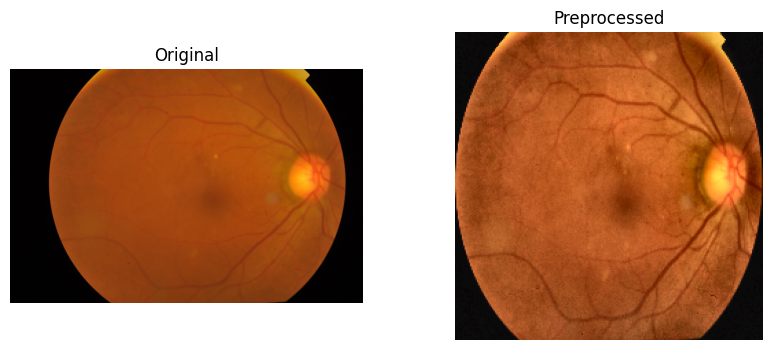

In [6]:
sample_path = train_paths[0]

orig = cv2.imread(sample_path)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)

proc = preprocess_image(sample_path)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(orig); plt.title("Original"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(proc); plt.title("Preprocessed"); plt.axis("off")
plt.show()


In [7]:
def extract_features(image):
    features = []
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # GLCM with multiple angles and distances
    glcm = graycomatrix(
        gray,
        distances=[1, 2, 3],
        angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
        levels=256,
        symmetric=True,
        normed=True
    )
    
    features += [
        graycoprops(glcm, 'contrast').mean(),
        graycoprops(glcm, 'energy').mean(),
        graycoprops(glcm, 'homogeneity').mean(),
        graycoprops(glcm, 'ASM').mean()
    ]
    
    # LBP texture
    lbp = local_binary_pattern(gray, 8, 1, method="uniform")
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 10))
    hist = hist.astype("float") / (hist.sum() + 1e-7)
    features += hist.tolist()
    
    # RGB color histograms
    for ch in cv2.split(image):
        h = cv2.calcHist([ch], [0], None, [32], [0, 256]).flatten()
        features += h.tolist()
    
    return features


In [8]:
X_train = []

for p in tqdm(train_paths):
    img = preprocess_image(p)
    feats = extract_features(img)
    X_train.append(feats)

X_train = np.array(X_train)
y_train = np.array(train_labels)

print("X_train:", X_train.shape)


100%|██████████| 2930/2930 [14:20<00:00,  3.41it/s]   


X_train: (2930, 109)


In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

pca = PCA(n_components=0.99)
X_train_pca = pca.fit_transform(X_train_scaled)

print("PCA components:", pca.n_components_)
print("X_train_pca:", X_train_pca.shape)


PCA components: 42
X_train_pca: (2930, 42)


In [10]:
rf = RandomForestClassifier(
    n_estimators=500,
    max_features='sqrt',
    class_weight='balanced_subsample',
    random_state=42
)

svm = SVC(
    kernel='rbf',
    C=10,
    gamma='scale',
    probability=True,
    class_weight='balanced'
)

lr = LogisticRegression(max_iter=3000, class_weight='balanced')
nb = GaussianNB()

rf.fit(X_train_pca, y_train)
svm.fit(X_train_pca, y_train)
lr.fit(X_train_pca, y_train)
nb.fit(X_train_pca, y_train)

print("Training Complete.")


Training Complete.


In [11]:
X_val = []

for p in tqdm(val_paths):
    img = preprocess_image(p)
    feats = extract_features(img)
    X_val.append(feats)

X_val = np.array(X_val)
y_val = np.array(val_labels)

print("X_val:", X_val.shape)


100%|██████████| 366/366 [01:32<00:00,  3.95it/s]

X_val: (366, 109)


In [12]:
X_val_scaled = scaler.transform(X_val)
X_val_pca = pca.transform(X_val_scaled)


In [13]:
models = {
    "RandomForest": rf,
    "SVM": svm,
    "LogisticRegression": lr,
    "NaiveBayes": nb
}

results = []

for name, model in models.items():
    preds = model.predict(X_val_pca)
    
    acc  = accuracy_score(y_val, preds)
    prec = precision_score(y_val, preds, average="weighted", zero_division=0)
    rec  = recall_score(y_val, preds, average="weighted", zero_division=0)
    f1   = f1_score(y_val, preds, average="weighted", zero_division=0)

    results.append([name, acc, prec, rec, f1])

    print(f"{name}  Acc={acc:.3f}  Prec={prec:.3f}  Rec={rec:.3f}  F1={f1:.3f}")

metrics_df = pd.DataFrame(results, columns=["Model","Accuracy","Precision","Recall","F1"])
metrics_df.to_csv("metrics.csv", index=False)

print("\nSaved metrics.csv")


RandomForest  Acc=0.765  Prec=0.759  Rec=0.765  F1=0.715
SVM  Acc=0.697  Prec=0.732  Rec=0.697  F1=0.705
LogisticRegression  Acc=0.664  Prec=0.747  Rec=0.664  F1=0.680
NaiveBayes  Acc=0.587  Prec=0.644  Rec=0.587  F1=0.597

Saved metrics.csv


In [14]:
os.makedirs("models", exist_ok=True)

joblib.dump(scaler, "models/scaler.pkl")
joblib.dump(pca, "models/pca.pkl")
joblib.dump(rf, "models/rf.pkl")
joblib.dump(svm, "models/svm.pkl")
joblib.dump(lr, "models/lr.pkl")
joblib.dump(nb, "models/nb.pkl")

print("Models saved in /models/")


Models saved in /models/
